# 95-891 Project

#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# All the codes below were run on Google Colab
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# The path of the data on my Google drive
data_dir = '/content/drive/MyDrive/Colab Notebooks/hw3_95891/project/skateboard'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


#### 1.2. Preview some images
Use PIL library to preview images

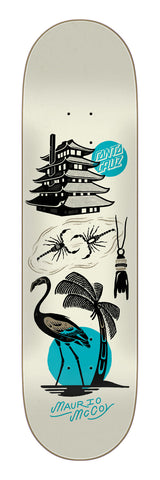

In [4]:
from PIL import Image  #show one example of image

Image.open("/content/drive/MyDrive/Colab Notebooks/hw3_95891/project/skateboard/train/santa/santa_cruze_deck_53.jpg")

In [35]:
# Resize the image with padding
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageOps

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, fill=(255,255,255))

folder_names = ['/train/', '/valid/', '/test/']
skateboard_brands = ['santa/', 'powell_peralta/', 'deathwish/']

for folder_name in folder_names:
  for brand in skateboard_brands:
    base_dir = data_dir + folder_name + brand
    img_names = [f for f in listdir(base_dir)]
    for img_name in img_names:
      img = Image.open(base_dir + img_name)
      img = resize_with_padding(img, (256, 256))
      if img.mode in ("RGBA", "P"): 
        img = img.convert("RGB")
      img.save(base_dir + img_name)

In [34]:
# img_names = [f for f in listdir('/content/drive/MyDrive/Colab Notebooks/hw3_95891/project/temp')]

# for img_name in img_names:
#   img = Image.open('/content/drive/MyDrive/Colab Notebooks/hw3_95891/project/temp/' + img_name)
#   img = resize_with_padding(img, (256, 256))
#   if img.mode in ("RGBA", "P"): 
#     img = img.convert("RGB")
#   img.save('/content/drive/MyDrive/Colab Notebooks/hw3_95891/project/temp/' + img_name)

#### 1.3. Data transformation and processing

In [36]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(256),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  5 batches of training images; each with 256 images
We have  1 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 256, 256])


#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown below
![picture](https://drive.google.com/uc?export=view&id=1XG8ZPxxcaOTaniTm-s_FdK4iRJbdMkhA)

Image credit: https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [37]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

### 1.5. Update the classifier of the model to be compatible with our datasets

In [38]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [41]:
# now we need to replace the classifier by our datasets

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_brands = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_brands)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.
<br>
It is used to avoid overfitting during the training stage.
- How does the dropout layer work during the prediction (evaluation) stage?
<br>
Typically, we don't use dropout layer during the prediction stage because we want to take into account all the units.

In [42]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)

            # Calculating metrics
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = deepcopy(model.state_dict())

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 1.1442358493804932
training accuracy per batch 0.35546875
epoch 0 summary
avg training loss per epoch 14.883042144775391
avg training accuracy per epoch 0.4186383903026581
avg validation loss per epoch 8.864953994750977
avg validation accuracy per epoch 0.42331287264823914

epoch 1 batch 0
training loss per batch 7.562095642089844
training accuracy per batch 0.453125
epoch 1 summary
avg training loss per epoch 3.5213956117630003
avg training accuracy per epoch 0.45446428656578064
avg validation loss per epoch 1.6187556982040405
avg validation accuracy per epoch 0.47852760553359985

epoch 2 batch 0
training loss per batch 1.6404533386230469
training accuracy per batch 0.390625
epoch 2 summary
avg training loss per epoch 1.2790148735046387
avg training accuracy per epoch 0.4611607134342194
avg validation loss per epoch 0.9421312808990479
avg validation accuracy per epoch 0.5276073813438416

epoch 3 batch 0
training loss per batch 1.0604819059371948

In [ ]:
# Calculate best_validation_accuracy
print(best_validation_accuracy / validation_len)

0.906992182135582


### 1.7. Draw learning curves

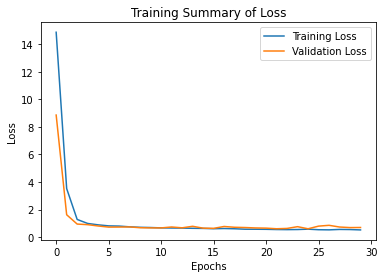

In [48]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

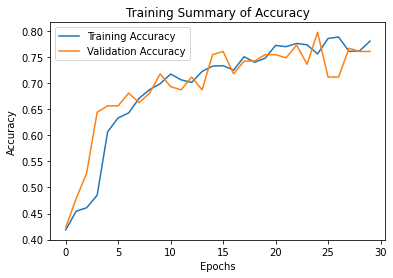

In [49]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 1.8. Predict on the test data with the best model so far

In [50]:
# Predict on the test data
from itertools import chain

# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:
    # Move images & labels to the GPU
    images, labels = images.to(device), labels.to(device)
    
    log_ps = model(images)
    ps = torch.exp(log_ps)
    top_ps, top_class = ps.topk(1, dim=1)

    # Save the predictions and labels for the test data
    label_data.extend(labels.cpu().data.numpy().tolist())
    predictions.extend(list(chain.from_iterable(top_class.cpu().data.numpy().tolist())))
    
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    test_batch_accuracy = matches.mean()
    
    # Tracking testing metrics
    test_accuracy += test_batch_accuracy.item()  

print('Test Accuracy:', test_accuracy / test_len)

Test Accuracy: 0.701298713684082


confusion matrix
[[4 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 6]]



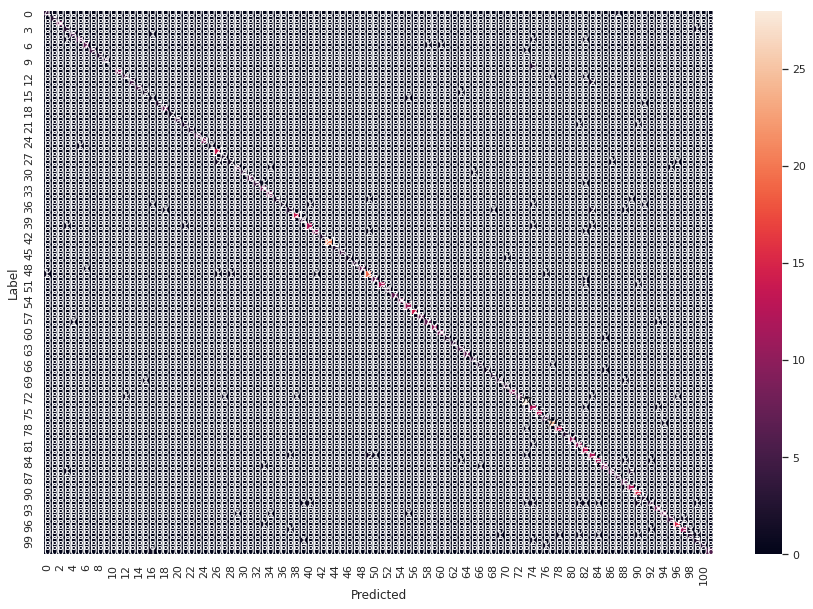

normalized confusion matrix
[[0.8        0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.6        0.         0.        ]
 [0.         0.         0.         ... 0.         0.75       0.        ]
 [0.         0.         0.         ... 0.         0.         0.85714286]]


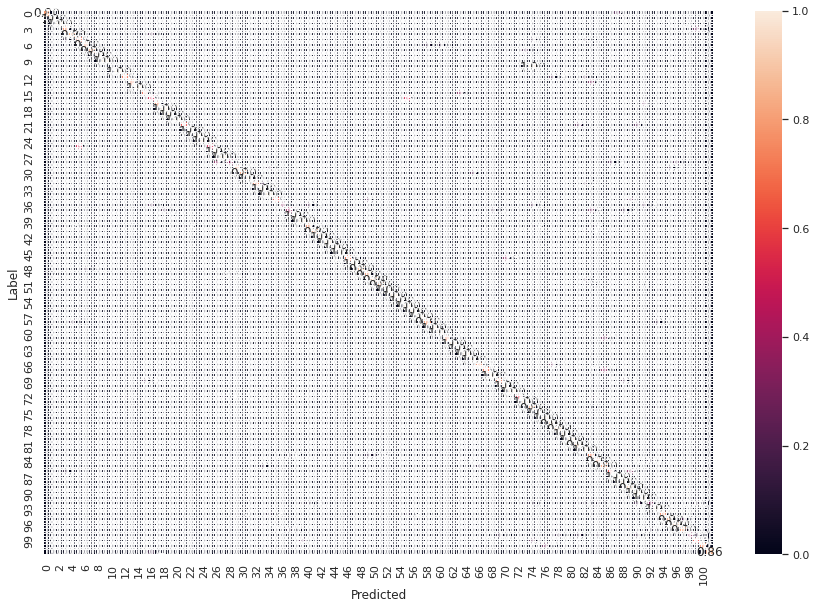

In [ ]:
# Please plot the confusion matrix other than print() if possible
from sklearn.metrics import confusion_matrix as conf_mat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# Get the confusion matrix
cf = conf_mat(label_data,predictions)
print('confusion matrix')
print(cf)
print()

# Plot the original confusion matrix
df_cf = pd.DataFrame(cf, range(len(class_to_idx)), range(len(class_to_idx)))
plt.figure(figsize=(15,10))
sn.heatmap(df_cf, annot=True)
plt.ylabel('Label')
plt.xlabel('Predicted')
plt.show()

# Normalize confusion matrix
print('normalized confusion matrix')
ncf = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
print(ncf)

# Plot the normalized confusion matrix
plt.figure(figsize=(15,10))
sn.heatmap(ncf, annot=True, fmt='.2f')
plt.ylabel('Label')
plt.xlabel('Predicted')
plt.show()